In [1]:
import navis
import navis.interfaces.microns as mi

In [2]:
# Initialize the client for the 65 part of cortical mm^3 (i.e. "Minnie")
client = mi.get_cave_client(datastack='cortex65')

# Fetch available annotation tables
client.materialize.get_tables()

['nucleus_detection_v0',
 'synapses_pni_2',
 'nucleus_neuron_svm',
 'proofreading_status_public_release',
 'func_unit_em_match_release',
 'allen_soma_ei_class_model_v1',
 'allen_visp_column_soma_coarse_types_v1']

In [3]:
ct = client.materialize.query_table('allen_soma_ei_class_model_v1')
ct.head()

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,485509,t,aibs_coarse_excitatory,excitatory,103588564537113366,864691136740606812,"[282608, 103808, 20318]"
1,113721,t,aibs_coarse_excitatory,excitatory,79951332685465031,864691135366988025,"[110208, 153664, 23546]"
2,263203,t,aibs_coarse_excitatory,excitatory,87694643458256575,864691135181741826,"[166512, 174176, 24523]"
3,456177,t,aibs_coarse_excitatory,excitatory,102677963354799688,864691135337690598,"[275616, 135120, 24873]"
4,364447,t,aibs_coarse_excitatory,excitatory,94449079618306553,864691136883828334,"[216064, 166800, 15025]"


In [4]:
ct.cell_type.unique()

array(['excitatory', 'inhibitory'], dtype=object)

In [5]:
# Fetch proof-reading status
pr = client.materialize.query_table('proofreading_status_public_release')
pr.head()

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,1,t,89529934389098311,864691136296964635,864691136296964635,extended,non,"[179808, 216672, 23361]"
1,2,t,90584228533843146,864691136311986237,864691136311986237,extended,non,"[187840, 207232, 22680]"
2,3,t,89528353773943370,864691135355207119,864691135355207119,extended,non,"[180016, 204592, 22798]"
3,4,t,91077153340676495,864691135355207375,864691135355207375,extended,non,"[191424, 209888, 22845]"
4,5,t,88897234233461709,864691136422983727,864691136422983727,extended,non,"[175248, 220944, 23561]"


In [6]:
# Subset to those neurons that have been proof read
proofread = pr[pr.status_dendrite.isin(['extented', 'clean']) & pr.status_axon.isin(['extented', 'clean'])].pt_root_id.values

ct = ct[ct.pt_root_id.isin(proofread)]
ct.shape

(167, 7)

In [7]:
# Pick 20 "root IDs" (sometimes also called segment IDs) each
inh_ids = ct[ct.cell_type == 'inhibitory'].pt_root_id.values[: 20]
exc_ids = ct[ct.cell_type == 'excitatory'].pt_root_id.values[: 20]

In [10]:
# Fetch those neurons
inh = mi.fetch_neurons(inh_ids, lod=2, with_synapses=False)
exc = mi.fetch_neurons(exc_ids, lod=2, with_synapses=False)

# Inspect
inh

Fetching:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching:   0%|          | 0/20 [00:00<?, ?it/s]

,type,name,id,units,n_vertices,n_faces
0,navis.MeshNeuron,None,864691135994731946,1 nanometer,118433,238637
1,navis.MeshNeuron,None,864691135974528623,1 nanometer,145727,293750
...,...,...,...,...,...,...
18,navis.MeshNeuron,None,864691136136830589,1 nanometer,54995,111098
19,navis.MeshNeuron,None,864691135428608048,1 nanometer,397265,799150


In [8]:
# Reduce face counts to 1/3 of the original
inh_ds = navis.simplify_mesh(inh, F=1/3)
exc_ds = navis.simplify_mesh(exc, F=1/3)

# Inspect (note the lower face/vertex counts)
inh_ds

Simplifying:   0%|          | 0/20 [00:00<?, ?it/s]

Simplifying:   0%|          | 0/20 [00:00<?, ?it/s]

,type,name,id,units,n_vertices,n_faces
0,navis.MeshNeuron,None,864691135994731946,1 nanometer,40887,79545
1,navis.MeshNeuron,None,864691135974528623,1 nanometer,50585,97915
...,...,...,...,...,...,...
18,navis.MeshNeuron,None,864691135446864980,1 nanometer,108886,213560
19,navis.MeshNeuron,None,864691135428608048,1 nanometer,136145,266382


In [ ]:
# Create some colors: reds for excitatory, blue for inhibitory
import seaborn as sns
colors = {n.id: sns.color_palette('Reds', 5)[i] for i, n in enumerate(exc[:5])}
colors.update({n.id: sns.color_palette('Blues', 5)[i] for i, n in enumerate(inh[:5])})

# Plot the first 5 neurons each
fig = navis.plot3d([inh_ds[:5], exc_ds[:5]], color=colors)

In [29]:
inh_sk = navis.skeletonize(inh, parallel=True)
exc_sk = navis.skeletonize(exc, parallel=True)

# Inspect 
inh_sk

Skeletonizing:   0%|          | 0/20 [00:00<?, ?it/s]

Skeletonizing:   0%|          | 0/20 [00:00<?, ?it/s]

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,None,864691135994731946,19099,None,482,591,1.064628e+07,11789,1 nanometer
1,navis.TreeNeuron,None,864691135974528623,24333,None,728,831,1.349213e+07,13008,1 nanometer
...,...,...,...,...,...,...,...,...,...,...
18,navis.TreeNeuron,None,864691136136830589,8257,None,276,341,4.566808e+06,5777,1 nanometer
19,navis.TreeNeuron,None,864691135428608048,62330,None,1109,1707,3.432125e+07,29927,1 nanometer


In [ ]:
# Plot one example (zoom in for details)
fig = navis.plot3d([inh_sk[0], inh[0]], color=[(1, 0, 0), (1, 1, 1, .5)])

In [30]:
# Create a combined DataFrame 
import pandas as pd 

inh_stats = inh_sk.summary()
inh_stats['type'] = 'inhibitory'

exc_stats = exc_sk.summary()
exc_stats['type'] = 'excitatory'

stats = pd.concat([inh_stats, exc_stats], axis=0)
stats.head()

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,inhibitory,None,864691135994731946,19099,None,482,591,1.064628e+07,11789,1 nanometer
1,inhibitory,None,864691135974528623,24333,None,728,831,1.349213e+07,13008,1 nanometer
2,inhibitory,None,864691135113360025,31313,None,698,1188,1.733779e+07,18923,1 nanometer
3,inhibitory,None,864691135700443515,45083,None,2484,1255,2.423469e+07,24681,1 nanometer
4,inhibitory,None,864691136521811345,10173,None,824,352,5.620049e+06,6607,1 nanometer


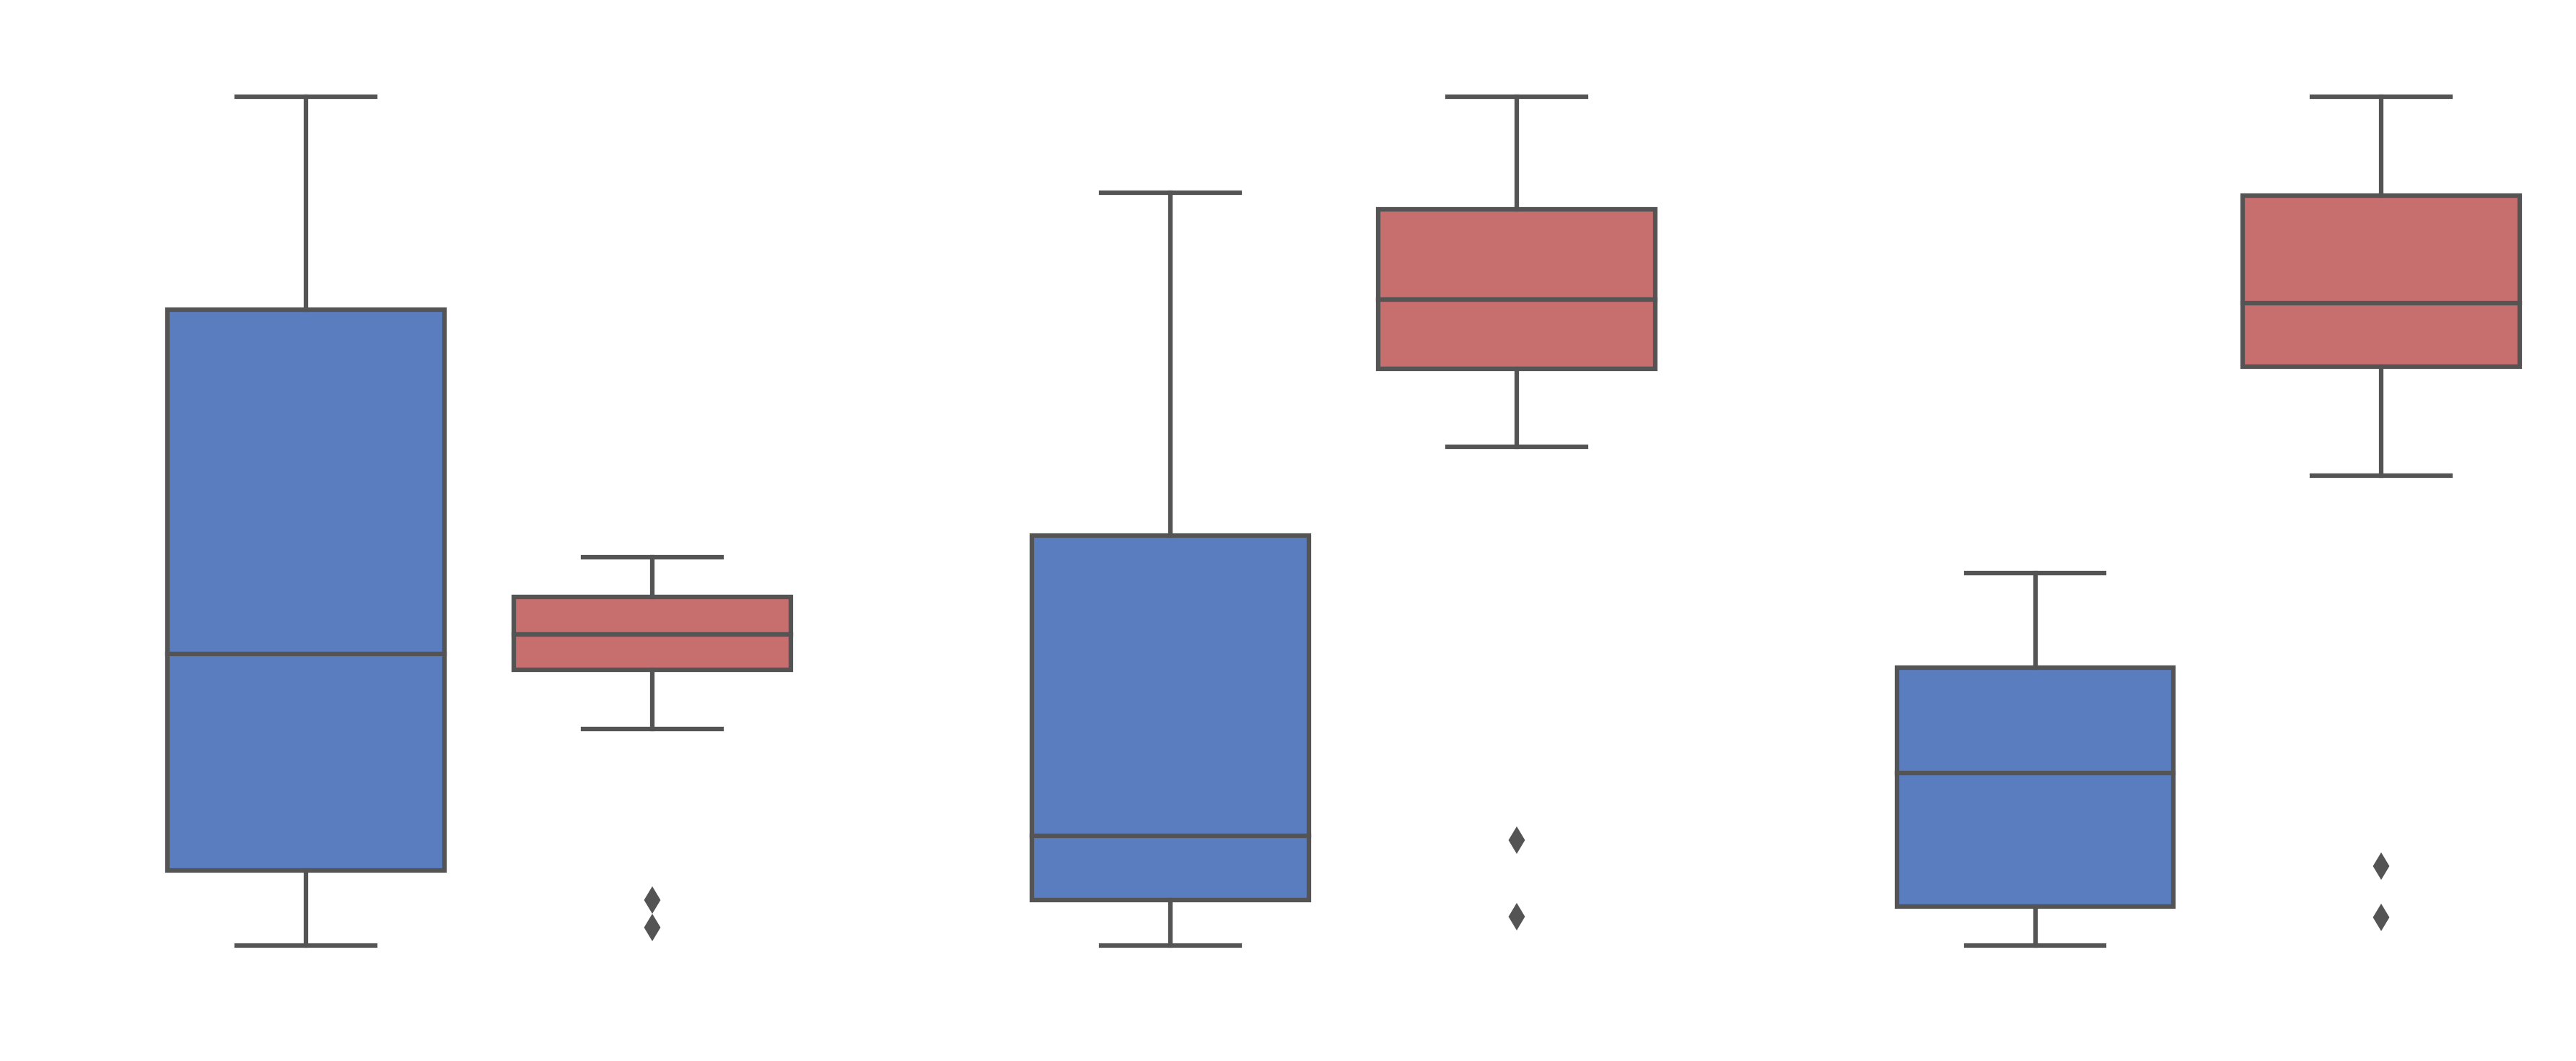

In [31]:
import matplotlib.pyplot as plt

sns.set_color_codes('muted')
plt.style.use('dark_background')  # comment this out if you have light background

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.patch.set_color((0, 0, 0, 0)) # Make background transparent

for col, label, ax in zip(['cable_length', 'n_branches', 'n_leafs'],
                          ['cable length  [nm]', '# of branch points', '# of leafs (tips)'],
                          axes):
    sns.boxplot(data=stats, y=col, x='type', ax=ax, palette=['b', 'r'])
    ax.set_ylabel(label)
    ax.set_xlabel('')
    ax.patch.set_color((0, 0, 0, 0)) # Make background transparent
    
sns.despine(trim=True)
plt.tight_layout()
plt.show()

In [11]:
# Perform Sholl analysis
import numpy as np
inh_sha = navis.sholl_analysis(inh, center='soma', radii=np.linspace(0, 1e6, 200), parallel=True)
exc_sha = navis.sholl_analysis(exc, center='soma', radii=np.linspace(0, 1e6, 200), parallel=True)

# The results are lists of DataFrames:
inh_sha[0].head()

Sholl analysis:   0%|          | 0/20 [00:00<?, ?it/s]

Sholl analysis:   0%|          | 0/20 [00:00<?, ?it/s]

,intersections,cable_length,branch_points
radius,,,
5025.125628,5,38364.963752,19
10050.251256,2,200485.343897,21
15075.376884,4,70893.601194,18
20100.502513,5,120444.934439,27
25125.628141,8,231928.170524,43


In [12]:
# Average across inhibitory and excitatory analyses
inh_sha_mean = inh_sha[0].copy()
for i in range(1, len(inh_sha)):
    inh_sha_mean += inh_sha[i].values
inh_sha_mean /= len(inh_sha)

exc_sha_mean = exc_sha[0].copy()
for i in range(1, len(exc_sha)):
    exc_sha_mean += exc_sha[i].values
exc_sha_mean /= len(exc_sha)

inh_sha_mean.head()

,intersections,cable_length,branch_points
radius,,,
5025.125628,4.05,34586.760812,17.10
10050.251256,1.95,118360.897060,18.75
15075.376884,2.60,78204.741723,13.10
20100.502513,4.25,104355.972463,21.00
25125.628141,5.65,150967.093900,27.00


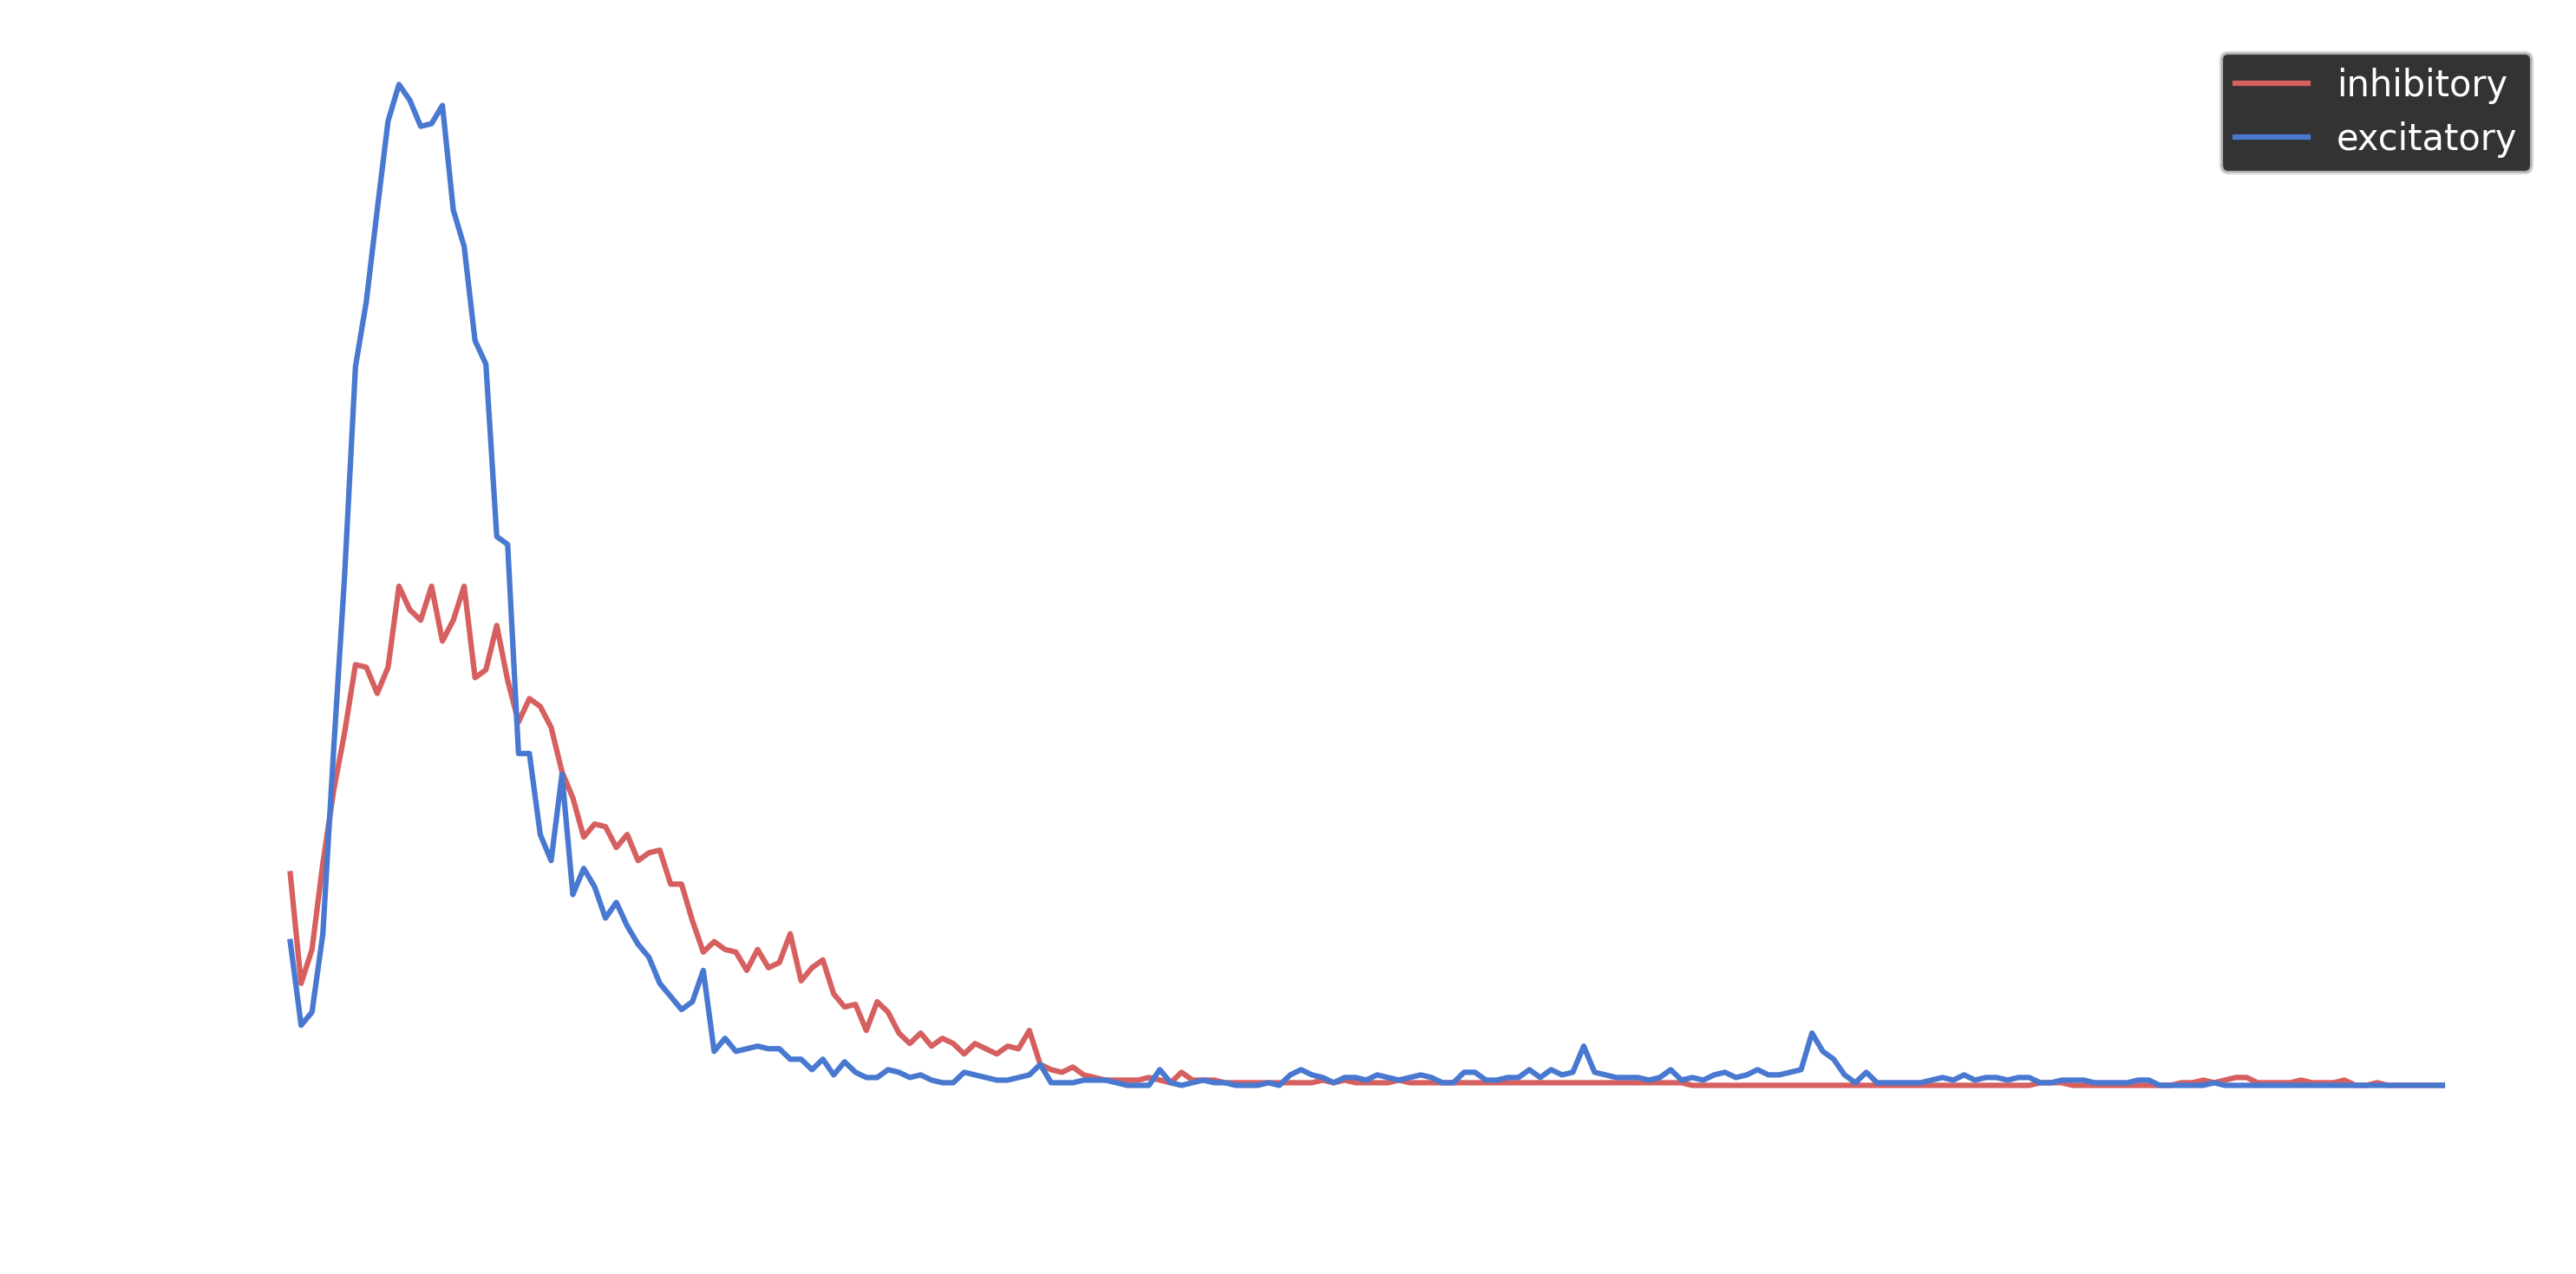

In [27]:
# Plot
fig, ax = plt.subplots(figsize=(10, 5))

inh_sha_mean.intersections.plot(c='r', label='inhibitory')
exc_sha_mean.intersections.plot(c='b', label='excitatory')

ax.set_ylabel('# of intersections')
ax.legend()
ax.patch.set_color((0, 0, 0, 0)) # Make background transparent
fig.patch.set_color((0, 0, 0, 0)) 

plt.tight_layout()
plt.show()

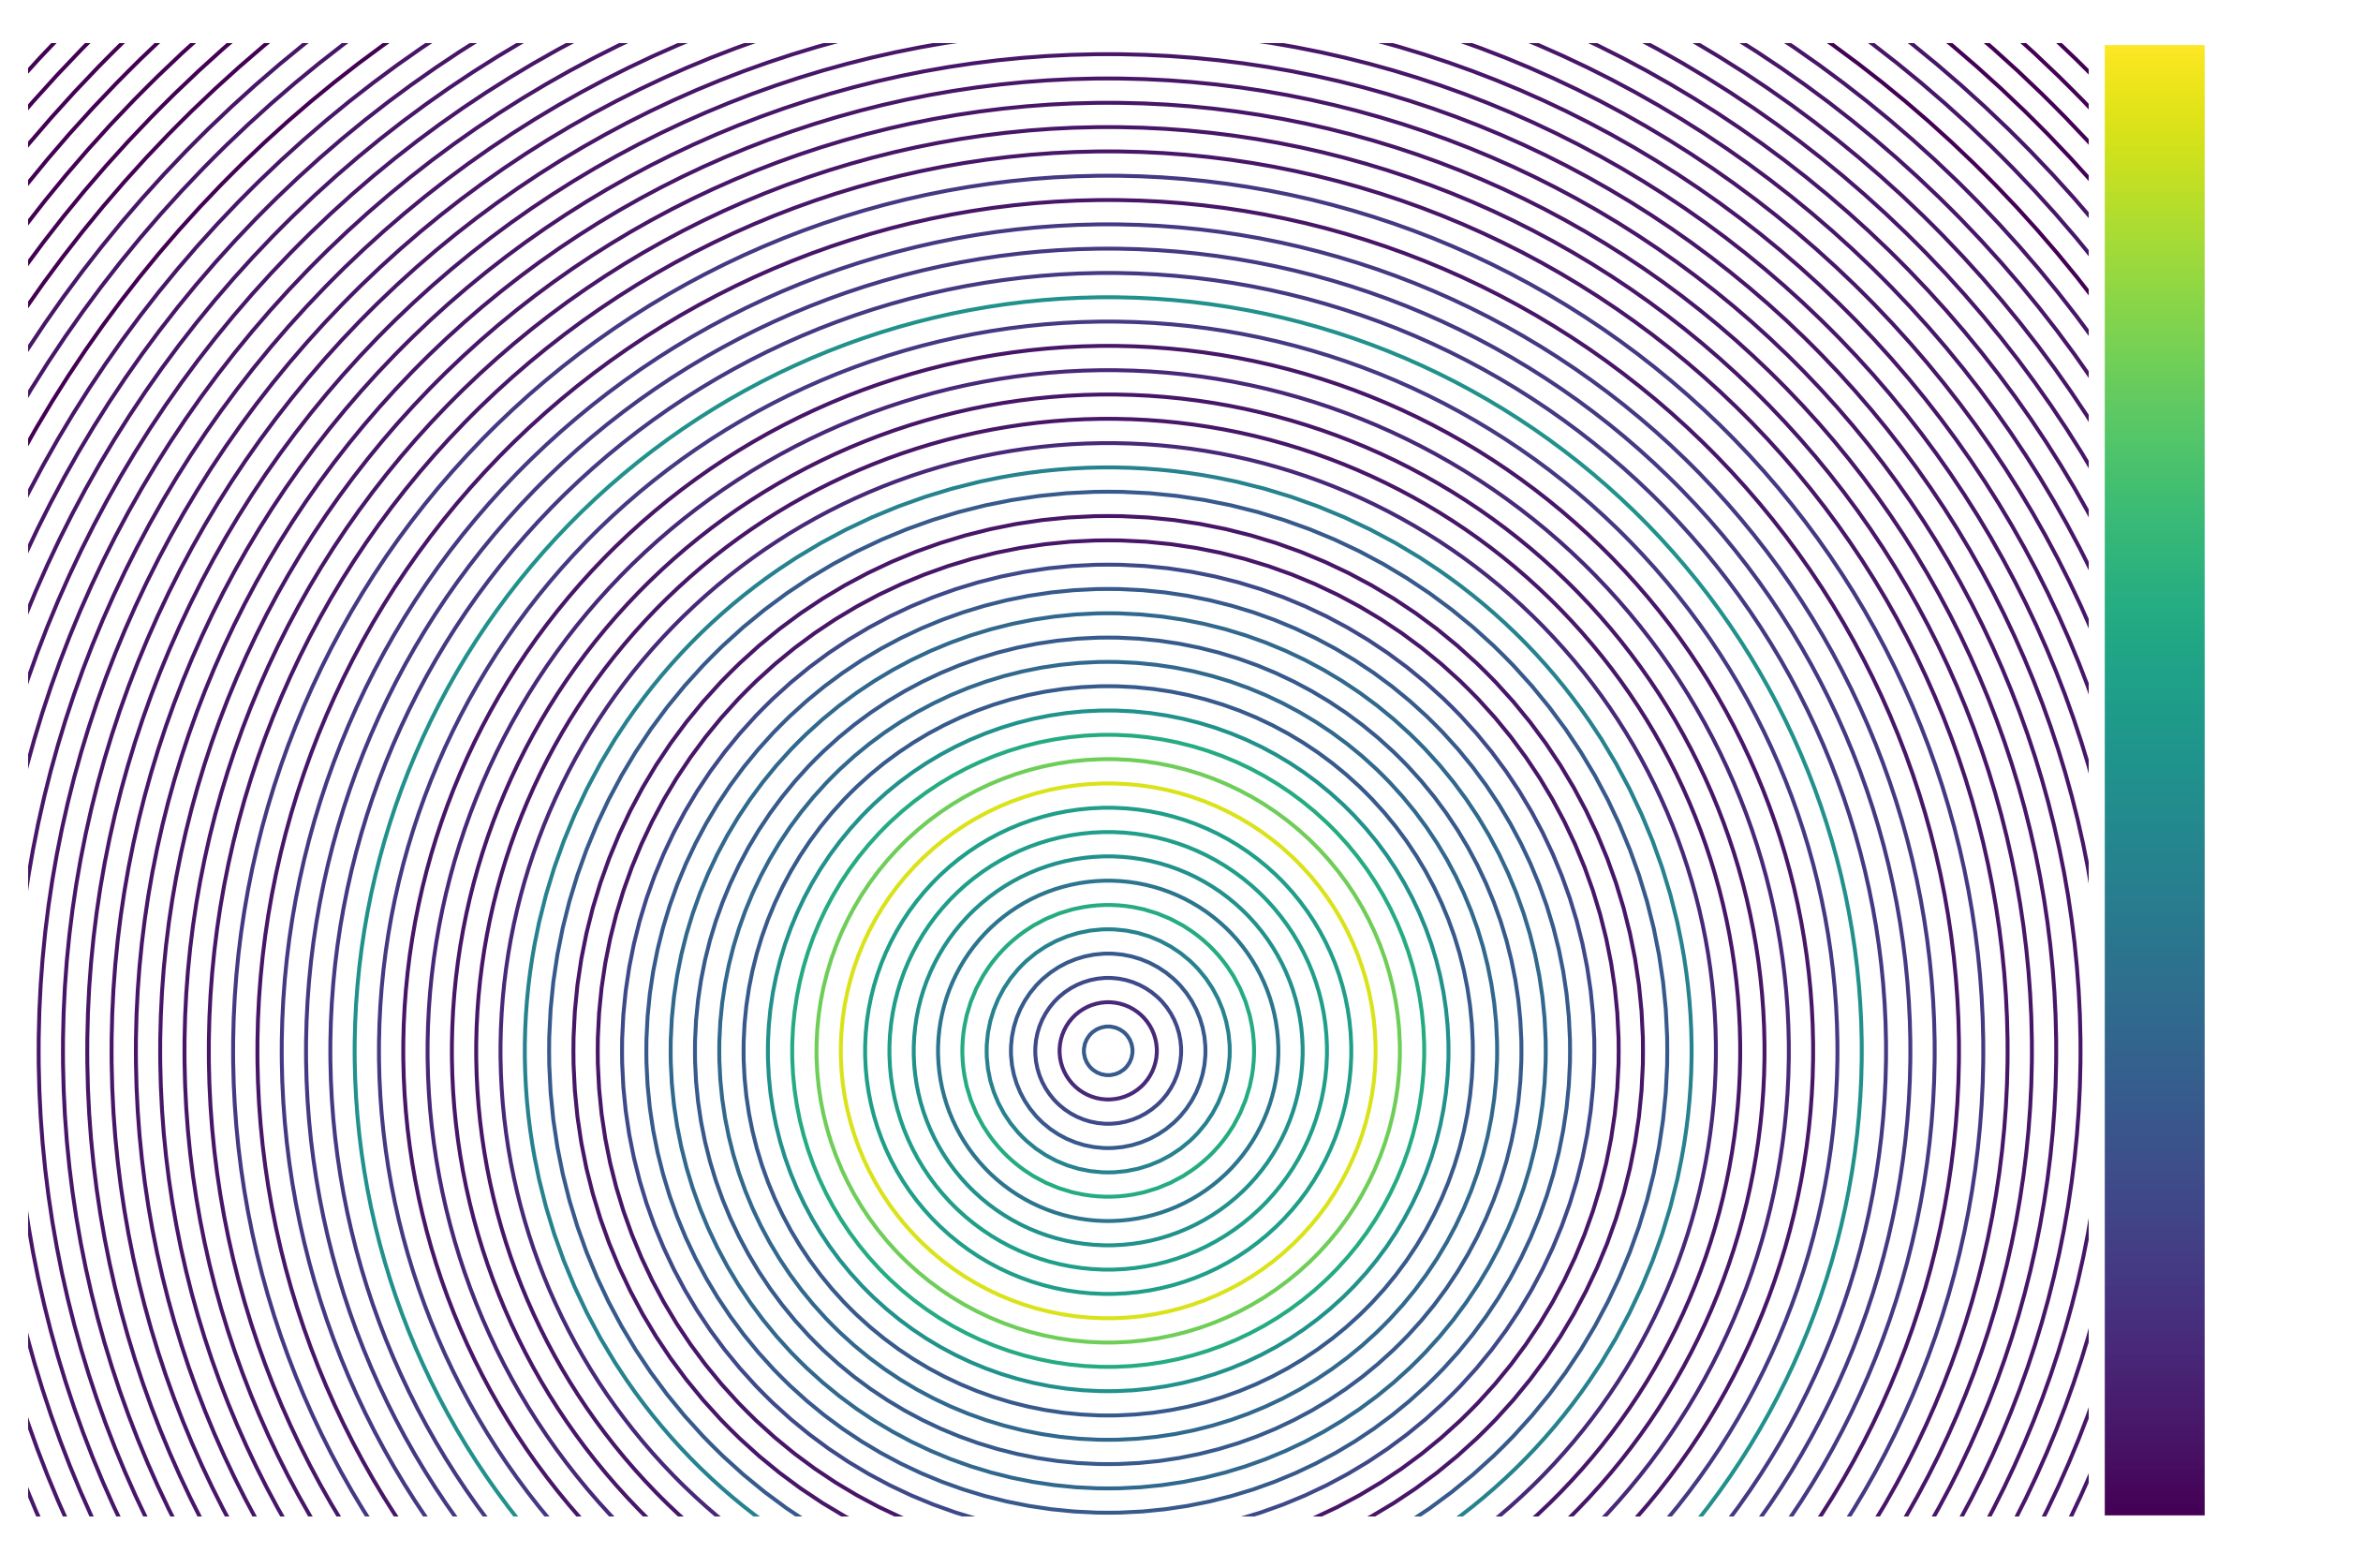

In [26]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot one of the inhibitory neurons
ix = 0
fig, ax = navis.plot2d(inh[ix], view=('x', 'y'), figsize=(10, 10), c='w', method='2d')

cmap = plt.get_cmap('viridis')

# Plot Sholl circles and color by number of intersections
center = inh[ix].soma_pos
norm = Normalize(vmin=0, vmax=(inh_sha[ix].intersections.max() + 1))
for r in inh_sha[0].index.values:
    ints = inh_sha[ix].loc[r, 'intersections']
    ints_norm = norm(ints)
    color = cmap(ints_norm)
    
    c = plt.Circle(center[:2], r, ec=color, fc='none')
    ax.add_patch(c)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='# of intersections')

plt.show()